In [229]:
from scipy.io import loadmat
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import scipy as sp
import matplotlib.pyplot as plt
import SolveTriangular

In [230]:
dati = loadmat("Test_I.mat")
A = dati["A"]
A = A.astype(float)
b = dati["b"]
b = b.astype(float)

In [231]:
n, m = A.shape
size = n * m
non_zeros = np.count_nonzero(A)

print(f"Dimensione di A: ({n}x{m})")
print("Simmetrica:", np.all(A.T == A))
print("Definita positiva:", np.all(npl.eigvals(A) > 0))
print("Sparsa:", non_zeros / size < 0.33)

Dimensione di A: (400x400)
Simmetrica: True
Definita positiva: True
Sparsa: True


In [232]:
def conjugate_gradient(A, b, x0, itmax, tol):
    n, m = A.shape
    if n != m:
        print("Matrice non quadrata")
        return [], []

    # inizializzare le variabili necessarie
    x = x0

    r = A @ x - b
    p = -r
    it = 0

    nb = np.linalg.norm(b)
    errore = np.linalg.norm(r) / nb
    vec_sol = []
    vec_sol.append(x0)
    vet_r = []
    vet_r.append(errore)

    # utilizzare il metodo del gradiente coniugato per calcolare la soluzione
    while errore >= tol and it < itmax:
        it = it + 1
        Ap = A @ p
        alpha = (r.T @ r) / (p.T @ Ap)
        x = x + alpha * p
        vec_sol.append(x)
        rtr_old = r.T @ r
        r = r + alpha * Ap
        gamma = (r.T @ r) / rtr_old
        errore = np.linalg.norm(r) / nb
        vet_r.append(errore)
        p = -r + gamma * p

    return x, vet_r, vec_sol, it

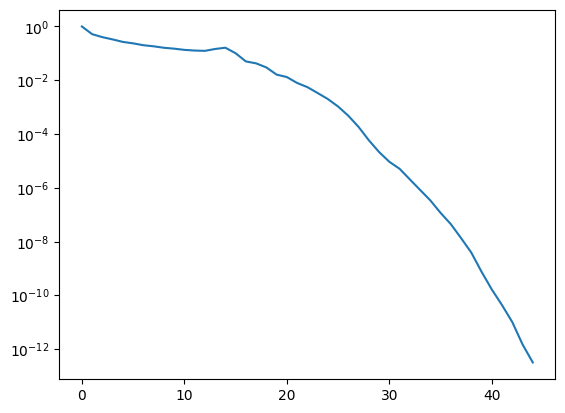

In [233]:
x0 = np.zeros_like(b)
itmax = 100
tol = 1e-12
x, vet_err, vec_sol, it = conjugate_gradient(A, b, x0, itmax, tol)

plt.semilogy(range(it + 1), vet_err)

> Il metodo del gradiente coniugato è il miglior metodo per le matrici di grandi dimensioni, sparse, simmetrice e definite positive. La simmetria e positività sono caratteristiche richieste per l'applicazione del metodo in quanto si basa sulla ricerca del minimio della funzione quadratica associata F(x) = 1/2\*<Ax,x> - <b, x> che ha minimo ed equivale al gradiente di F solo se la matrice Hessiana, che corrisponde ad A (per simmetria) è definita positiva. A differenza del metodo del gradiente il metodo del gradiente coniugato prende in considerazione non solo la direzione dell'antigradiente ma anche la direzione coniugata a quella precedente, il che permette una convergenza più veloce evitando il movimento a zig-zag. Inoltre il metodo del gradiente opera solamente sugli elementi non nulli, ciò vuol dire che sfrutta l'essere sparsa della matrice.


In [234]:
L = np.array([-55, -45, -35, -25, -15, -5, 5, 15, 25, 35, 45, 55, 65])
T = np.array(
    [3.7, 3.7, 3.52, 3.27, 3.2, 3.15, 3.15, 3.25, 3.47, 3.52, 3.65, 3.67, 3.52]
)

In [235]:
def plagr(xnodi, j):
    """
    Restituisce i coefficienti del j-esimo pol di
    Lagrange associato ai punti del vettore xnodi
    """
    xzeri = np.zeros_like(xnodi)
    n = xnodi.size
    if j == 0:
        xzeri = xnodi[1:n]
    else:
        xzeri = np.append(xnodi[:j], xnodi[j + 1 :])

    num = np.poly(xzeri)
    den = np.polyval(num, xnodi[j])

    p = num / den

    return p

In [236]:
def InterpL(x, y, xx):
    """ "
    %funzione che determina in un insieme di punti il valore del polinomio
    %interpolante ottenuto dalla formula di Lagrange.
    % DATI INPUT
    %  x  vettore con i nodi dell'interpolazione
    %  f  vettore con i valori dei nodi
    %  xx vettore con i punti in cui si vuole calcolare il polinomio
    % DATI OUTPUT
    %  y vettore contenente i valori assunti dal polinomio interpolante
    %
    """
    n = x.size
    m = xx.size
    L = np.zeros((m, n))
    for j in range(n):
        p = plagr(x, j)
        L[:, j] = np.polyval(p, xx)

    return L @ y

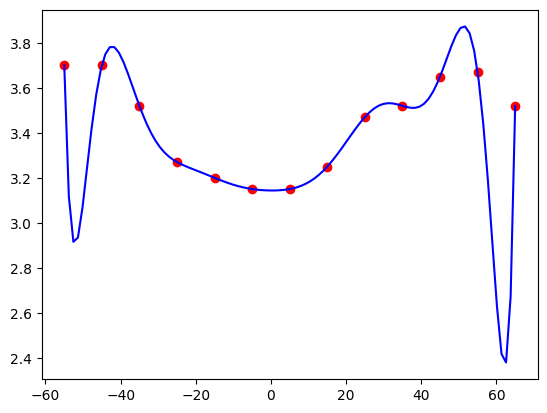

In [237]:
xx = np.linspace(np.min(L), np.max(L), 100)
yy = InterpL(L, T, xx)

plt.plot(L, T, "ro", xx, yy, "b-")

In [238]:
L_alaska = np.array([61.2])
T_alaska = InterpL(L, T, L_alaska)
print(f"{T_alaska=}")

T_alaska=array([2.43821067])


> Per via della scelta dei punti di interpolazione in un intervallo equidistante e dall'alto grado del polinomio, si vericano delle forti fluttazioni agli estremi dell'intervallo, per evitare questo fenomeno e quindi minimizzare l'errore |f(x) - P(x)| = 1/(n+1)! \* w_n+1(x) + f^n+1(e) sarebbe meglio utilizzare come punti di interpolazione gli zeri del polinomio di chebishev


In [239]:
def eqnorm(A, b):
    # Risolve un sistema sovradeterminato con il metodo delle equazioni normali
    G = A.T @ A
    f = A.T @ b

    L = spl.cholesky(G, lower=True)
    U = L.T

    z, flag = SolveTriangular.Lsolve(L, f)
    x, flag = SolveTriangular.Usolve(U, z)

    return x

In [240]:
def PRegression(x, y, xx):
    n = 5
    B = np.vander(x, n + 1, increasing=True)
    alpha = eqnorm(B, y)
    return np.polyval(np.flip(alpha), xx)

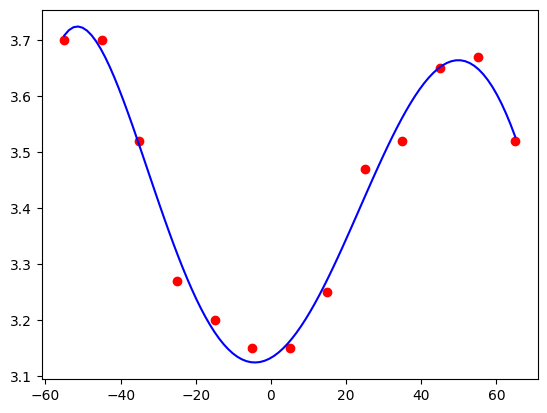

In [241]:
xx = np.linspace(np.min(L), np.max(L), 100)
yy = PRegression(L, T, xx)

plt.plot(L, T, "ro", xx, yy, "b-")

In [242]:
L_alaska = np.array([61.2])
T_alaska = PRegression(L, T, L_alaska)
print(f"{T_alaska=}")

T_alaska=array([3.58886008])
